imports

In [74]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix,f1_score,precision_score
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

divide in test and train

In [75]:
clean_data = pd.read_csv('data/clean_data.csv')
#drop -1 in is_recid
clean_data = clean_data[clean_data['is_recid'] != -1]

clean_data['c_jail_in'] = pd.to_datetime(clean_data['c_jail_in'], format='%d/%m/%Y %H:%M', dayfirst=True)
clean_data['c_jail_out'] = pd.to_datetime(clean_data['c_jail_out'], format='%d/%m/%Y %H:%M', dayfirst=True)
clean_data['duration'] = abs((clean_data['c_jail_out'] - clean_data['c_jail_in']).dt.days) + 1
clean_data['duration'] = clean_data['duration'].fillna(0)
clean_data['duration'] = clean_data['duration'].astype('int')
clean_data = clean_data[clean_data['is_recid'] != -1]
clean_data = clean_data.drop(['vr_charge_degree','is_violent_recid','r_charge_degree','id', 'c_jail_in', 'c_jail_out', 'age', 'dob', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'days_b_screening_arrest', 'c_days_from_compas', 'r_offense_date', 'r_charge_desc', 'r_jail_in','vr_offense_date','vr_charge_desc','score_text','screening_date','v_decile_score','v_score_text','priors_count.1','r_days_from_arrest'], axis=1) 
print(clean_data.columns)
def random_test_train(data):
    
    train_data = data.sample(frac=0.8, random_state=0)
    test_data = data.drop(train_data.index)
    return train_data, test_data

train_data, test_data = random_test_train(clean_data)


Index(['name', 'sex', 'age_cat', 'race', 'decile_score', 'priors_count',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'event', 'duration'],
      dtype='object')


encoded categories and clean

In [76]:
def encode_categorical_features(data):
    le = preprocessing.LabelEncoder()

    new_data = data.copy()
    for column in data.columns:
        if data[column].dtype == type(object):
            new_data[column] = le.fit_transform(data[column])
    return new_data


encode_categorical_features(train_data)

,name,sex,age_cat,race,decile_score,priors_count,c_charge_degree,c_charge_desc,is_recid,event,duration
7634,6653,1,1,0,1,0,7,52,1,0,1
4693,3983,1,0,2,1,1,3,342,1,0,1
8922,5170,1,0,0,1,3,3,25,1,0,2
502,2360,1,1,0,8,23,7,319,1,0,1
12079,7604,1,2,0,3,1,3,349,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...
12237,2160,0,1,2,7,0,3,212,1,0,7
3031,4205,1,0,0,8,4,3,315,0,0,34
6356,43,1,2,5,10,5,7,375,1,1,33
10902,5845,1,0,3,8,2,3,212,0,0,4


divide train data randomly for training

In [77]:
def random_train_data_in_k_sample(train_data,k):
    if k ==1:
        return [encode_categorical_features(train_data)]
    else:
        
        train_data = encode_categorical_features(train_data)
        #shuffle
        shuffled_data = train_data.sample(frac=1)
        split_data = np.array_split(shuffled_data, k)
        return split_data


    


prediction

In [78]:
def decisional_tree(liste_data):
    results= [] #empty list to store the results
    for i in range(len(liste_data)):

        
        # Split the data into a training set and a test set
        train = liste_data[i]
        #training
        clf = tree.DecisionTreeClassifier(max_depth=5,splitter='best',criterion='entropy')
        clf = clf.fit(train.drop("is_recid", axis=1), train["is_recid"])
        
        # Predict the test set
        predictions = clf.predict(train.drop("is_recid", axis=1))
        accuracy = clf.score(train.drop("is_recid", axis=1), train["is_recid"])
        f1 = f1_score(train["is_recid"], predictions)
        precision = precision_score(train['is_recid'], predictions)

        
        results.append({
            'model':clf,
            'predictions':predictions,
            'accuracy':accuracy,
            'f1':f1,
            'precision':precision,
        })
        
    return results
        


get the best predictions by accuracy of all trees made

In [79]:
def get_best_model(results,test_data):
    best_score = 0
    best_model = None
    for result in results:
        score = result['accuracy'] + result['f1'] + result['precision']
        if score > best_score:
            best_model = result['model']
            best_score = score
    best_predicitons = best_model.predict(test_data.drop("is_recid", axis=1))
    accuracy = best_model.score(test_data.drop("is_recid", axis=1), test_data["is_recid"])
    # print(f"accuracy :  {accuracy}")
    precision = precision_score(test_data['is_recid'], best_predicitons)
    # print(f"precision :  {precision}")
    f1 = f1_score(test_data["is_recid"], best_predicitons)
    # print(f"f1 :  {f1}")
    cm = confusion_matrix(test_data["is_recid"], best_predicitons)
    # print(f"Confusion matrix:\n{cm}")
    
    
    result = {
        "score" : accuracy+precision+f1,
        "accuracy": accuracy,
        "model": best_model,
        "f1": f1,
        "precision": precision,
        "cm":cm,
        "prediction": best_predicitons
        
    }
    return result

# print(get_best_model(decisional_tree(random_train_data_in_k_sample(train_data,3)),encode_categorical_features(test_data)))

Let's train

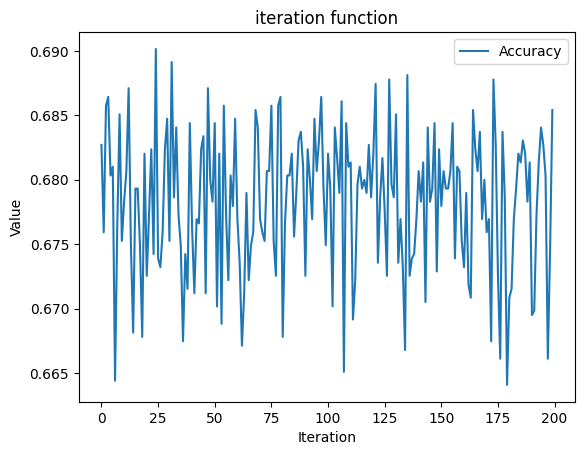

Best accuracy is 0.6901456146291907
Best iteration is 24
Best precision is 0.70995670995671
Best f1 is 0.5891333632689717
Best confusion matrix is  
 [[1382  268]
 [ 647  656]]


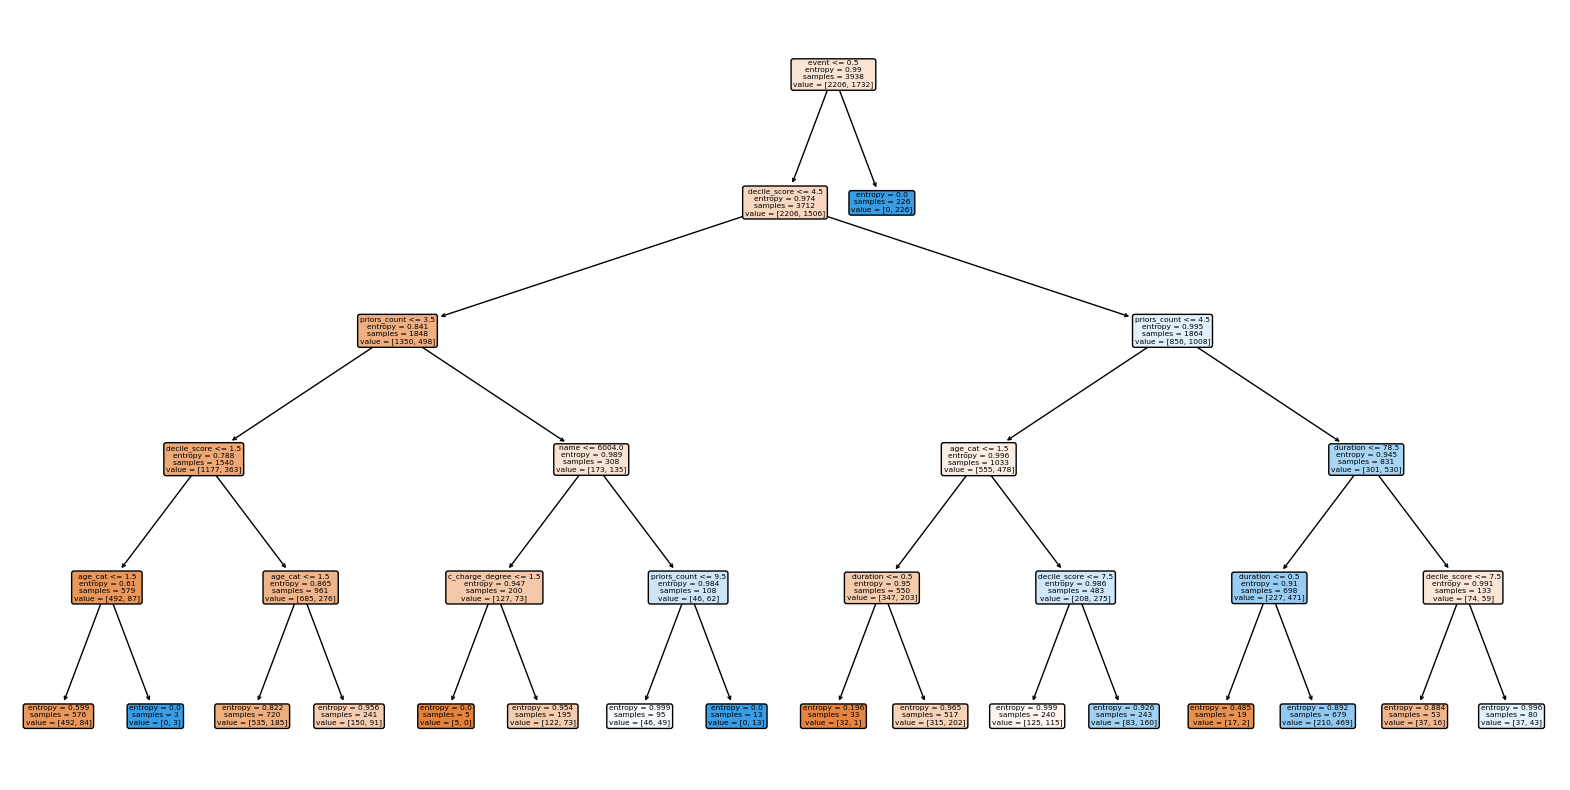

In [80]:
def get_best_of_all(data,k,max_iter):
    best_score = 0
    scores = []
    accuracies = []
    best_model = None
    best_i = 0
    best_accuracy = 0
    best_f1 = 0
    best_precision = 0
    best_cm = None
    for i in range(max_iter):
        train_data, test_data = random_test_train(data)
        result = get_best_model(decisional_tree(random_train_data_in_k_sample(train_data,k)),encode_categorical_features(test_data))
        scores.append(result['score'])
        accuracies.append(result['accuracy'])
        if result['score'] > best_score:
            best_score = result['score']
            best_model = result['model']
            best_accuracy = result['accuracy']
            best_i = i
            best_f1 = result['f1']
            best_precision = result['precision']
            best_cm = result['cm']
        
    
    #plot iteration vs score and accuracy
    plt.plot(range(max_iter),accuracies, label='Accuracy')
    plt.xlabel('Iteration')
    plt.ylabel('Value')
    plt.legend()
    plt.title("iteration function")
    plt.show()
    
    print(f"Best accuracy is {best_accuracy}")
    print(f"Best iteration is {best_i}")
    print(f"Best precision is {best_precision}")
    print(f"Best f1 is {best_f1}")
    print(f"Best confusion matrix is  \n {best_cm}")
    plt.figure(figsize=(20,10))  # Set the figure size
    plot_tree(best_model, filled=True, rounded=True, feature_names=test_data.drop("is_recid", axis=1).columns)
    plt.show()
    
    #test the best model on the complete data in order to make new statistiques after
        
    
    final_prediction = best_model.predict(encode_categorical_features(data).drop("is_recid", axis=1))
    final_prediction = pd.DataFrame(final_prediction,columns=['prediction'])
    data.reset_index(drop=True, inplace=True)
    final_data = pd.concat([data, final_prediction], axis=1, sort=False)
    final_data.to_csv('data/prediction_with_decisional_tree.csv', index=False)


    
get_best_of_all(clean_data,3,200)  